In [87]:
import xml.etree.ElementTree as ET
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import RandomState


import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torch.optim as optim

from torch import nn
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms
from sklearn.model_selection import KFold
from sklearn.metrics import plot_confusion_matrix

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

from math import sqrt

In [88]:
import warnings
warnings.filterwarnings('ignore')

In [89]:
class imgsTortugas(Dataset):

    def __init__(self, ruta_imgs = '/datasets/imgs', 
                       ruta_labels = '/datasets/annotations',
                       transform = None):
        """
        
            Dentro de la función __init__ incluímos todo lo que queremos que pase cuando creamos el dataset,
            así cómo los argumentos con los que lo vamos a crear. En este caso, algunos argumentos los guardamos
            para usar más tarde, y además cargamos las anotaciones en un pandas dataframe

            Args:
                · ruta_imgs (string): directorio que contiene todos los archivos .jpeg con las imgs.
                · ruta_labels (string): directorio que contiene todos los archivos con las anotaciones (en .xml)
                · transform: una transformación o composición de transformaciones que se usarán para data augmentation
                
        """

        # Guardar ruta_imgs para usar más adelante
        self.ruta_imgs = ruta_imgs

        # Labels: tenemos que cargar los .xml y convertirlos en un dataframe. Para que quede más prolijo,
        # lo hacemos en una función aparte, en la próxima celda
        self.annotations_df = load_annotations(ruta_labels)
        self.ruta_etiquetas = ruta_labels

    def __len__(self):        
        return len(self.annotations_df)

    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Primero, extraemos, del dataframe con las anotaciones, las esquinas de la bounding box y las convertimos
        # en un tensor, que es el tipo de dato que usa pytorch en el entrenamiento de redes.
        row = self.annotations_df.loc[idx]
        bbox = torch.tensor(((row['x_min'],row['y_min']),(row['x_max'],row['y_max'])))

        # Cargar la imagen usando el nombre de archivo leido de la tabla con las anotaciones.
        labels_filename = os.path.split(self.annotations_df.filename[idx])[-1][:-4]
        img_filename = os.path.join(self.ruta_imgs, labels_filename + '.jpg')
        self.nombreimagen= labels_filename
    
        # Usamos el módulo Image de Pillow (PIL) para cargar la imagen
        img = Image.open(img_filename)

        # Luego extraemos los datos de pixel en un numpy array
        img_array = np.asarray(img)
        
        # Preprocesamiento:
        # -----------------
        # Este sería el punto donde aplicaríamos otras operaciones a la imagen. Por ahora,
        # lo único que vamos a dejar programado es convertir la imagen en un tensor.

        # 1) Convertir en un tensor
        img_array = torch.tensor(img_array, dtype = torch.float32)     
        
        
        # Finalmente, vamos a programar qué devuelve el dataset cuando le pedimos un elemento.
        # Por ahora, le vamos a pedir que devuelva lo mínimo que necesitamos para entrenar la red: los datos de pixel
        # y la posición de la bounding box
        
        sample = {'image': img_array, 'bbox': bbox}

        return sample

In [90]:
def load_annotations(path):

    """
    
        Esta función toma como entrada el directorio con todos los .xml con las anotaciones, y crea un pandas dataframe
        con los datos.
    
    """

    # Hacer una lista con todos los archivos en el directorio
    file_list = os.listdir(path)

    # Recorrer todos los archivos, y para cada archivo armar una fila del dataframe
    rows = []
    for file in file_list:

        # Generar una lista para ir armando la fila
        row = []

        # Unir la ruta con el nombre archivo
        file_path = os.path.join(path, file)
        extension = file_path[-3:]
        if extension == 'xml':
            # Guardar en la lista
            row.append(file_path)

            # Extraer la informacion de la bounding box del xml.

            root = ET.parse(file_path).getroot()
            polygon = root.find('./object/polygon')
            
            row.append(min( int(polygon[1].find('x').text), int(polygon[3].find('x').text)))
            row.append(max( int(polygon[1].find('x').text), int(polygon[3].find('x').text)))
            row.append(min( int(polygon[1].find('y').text), int(polygon[3].find('y').text)))
            row.append(max( int(polygon[1].find('y').text), int(polygon[3].find('y').text)))
            
            # Crear la nueva fila con estos datos
            rows.append(row)
            
    # Crear el dataframe
    df = pd.DataFrame(rows, columns = ['filename','x_min','x_max','y_min','y_max'])
    return df 

In [91]:
dataset_full = imgsTortugas(ruta_imgs = "datasets/imgs",
                            ruta_labels = "datasets/annotations")

# Los labels de los .xml ya deberían haberse cargado. Lo chequeamos:
dataset_full.annotations_df.head()

,filename,x_min,x_max,y_min,y_max
0,datasets/annotations\0002iresized.xml,40,58,103,128
1,datasets/annotations\0003iresized.xml,77,154,54,159
2,datasets/annotations\0005iresized.xml,61,93,82,114
3,datasets/annotations\0007iresized.xml,95,123,129,157
4,datasets/annotations\0008iresized.xml,85,102,127,148


In [92]:
def create_rect(bb, color='red'):
    """
        Crea un objeto matplotlib.patches.Rectangle a partir de las coordenadas de la bounding box.

        Args:
            · bb: coordenadas de las esquinas de la bounding box, en este formato:
            ((xmin,ymin),(xmax,ymax))
    """
    bb = bb.numpy()

    return plt.Rectangle((bb[0][0], bb[0][1]), bb[1][0] - bb[0][0], bb[1][1] - bb[0][1], color=color,
                         fill=False, lw=3)

def add_bb_to_axes(ax, bb, color='red'):
    """
    
        Toma un handler de una imagen pyplot (ax) y le agrega el bounding box indicado por las coordenadas bb

    """
    
    ax.add_patch(create_rect(bb, color = color))

def show_img_with_bb(im, bb, color='red'):
    """
    
    Muestra una imagen junto con su bounding box    

    """
    ax = plt.gca()
    plt.imshow(im)
    add_bb_to_axes(ax, bb, color)

In [93]:
# 80% de los datos para training
train_fraction = 0.7

# 10% para test (y los 10% que quedan son para evaluación)
test_fraction = 0.1

# Convertimos esos porcentajes a números (enteros)
train_size = int(train_fraction * len(dataset_full))
test_size = int(test_fraction * len(dataset_full))
eval_size = len(dataset_full) - train_size - test_size
#Armar indices para los sets
# Hacemos una lista de números del 0 al 999 (o al tamaño del dataset completo)
indices = np.arange(len(dataset_full))

# Mezclamos esa lista en forma aleatoria.
# La parte de RandomState(random_seed) se usa para controlar como es esa mezcla. random_seed es un número cualquiera (no importa el valor)
# que elegimos a mano. Lo importante es que, si no lo cambiamos, la mezcla siempre va a ser la misma. Esto nos permite generar siempre los
# mismos conjuntos de train, test y eval (si es que queremos eso). Si queremos diferentes conjuntos, cambiamos el valor de random_seed.
random_seed = 112
RandomState(random_seed).shuffle(indices)

# De la lista mezclada, extraemos los indices correspondiente a cada subconjunto.
indices_train = indices[0:train_size]
indices_test = indices[train_size:train_size + test_size]
indices_eval = indices[train_size + test_size:]

## Pasamos por el mejor modelo

In [94]:
valid_subsampler = torch.utils.data.SubsetRandomSampler(indices_eval)
validloader = DataLoader(dataset_full, batch_size=5,sampler=valid_subsampler)

In [95]:
dataset_eval = torch.utils.data.Subset(dataset_full, indices_eval)

In [96]:
best_model = models.resnet18(pretrained = True)
best_model.fc = torch.nn.Linear(in_features = 512, out_features = 4, bias = True)

checkpoint = torch.load('outputs/best_model.pth')
best_model.load_state_dict(checkpoint['state_dict'])


optimizer = optim.Adam(best_model.parameters(), lr = 0.001)
optimizer.load_state_dict(checkpoint['optimizer'])

epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [97]:
## Intersection over union

In [98]:
## al tensor hay que llamarlo de distinta manera

def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0:1,0], boxB[0:1,0])
    yA = max(boxA[0:1,1], boxB[0:1,1])
    xB = min(boxA[0:1,2], boxB[0:1,2])
    yB = min(boxA[0:1,3], boxB[0:1,3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[0:1,2] - boxA[0:1,0]) * (boxA[0:1,3] - boxA[0:1,1]))
    boxBArea = abs((boxB[0:1,2] - boxB[0:1,0]) * (boxB[0:1,3] - boxB[0:1,1]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    iou_numpy = np.array(iou)

    # return the intersection over union value
    return iou_numpy

In [99]:
## Funciones de pérdida

In [100]:
# Mean Squared Error Loss Function
MSE = torch.nn.MSELoss()

#Mean absolute error
MAE= torch.nn.L1Loss()

#Kullback-Leibler Divergence Loss Function
divergence= torch.nn.KLDivLoss()

#Negative log likelihood loss with Poisson distribution of target.
poisson = nn.PoissonNLLLoss()

#Gaussian negative log likelihood loss.
gausian = nn.GaussianNLLLoss()
var = torch.ones(1, 4, requires_grad=True)

#In statistics, the Huber loss is a loss function used in robust regression, that is less sensitive
#to outliers in data than the squared error loss. 
huber = torch.nn.HuberLoss()

#SMOOTHL1LOSS
smoth = torch.nn.SmoothL1Loss(beta=1.0)

#R2
from sklearn.metrics import r2_score

#explained_variance_score
from sklearn.metrics import explained_variance_score

In [101]:
indices_eval.size

199

In [102]:
dataset_eval = torch.utils.data.Subset(dataset_full, indices_eval)
print(type(dataset_eval))
print(dataset_eval)

# Recorrer todo el dataset de evaluación
idx_list=[]
area_list = []
MSE_list=[]
RMSE_list = []
MAE_list=[]
divergence_list = []
poison_list = []
gausian_list = []
huber_list = []
smoth_list = []
iou_list=[]

for idx, element in enumerate(dataset_eval):

    # Extraer la imagen del dataset
    image = element['image']
    data = image.permute([2,1,0]).unsqueeze(0)
#     print(data.shape)

    bb_label = dataset_eval[idx]['bbox']
    target = bb_label.unsqueeze(0)
#     unsqueeze: Returns a new tensor with a dimension of size one inserted at the specified position.
    target = target.reshape([int(target.numel()/4),4]).type(torch.float)  
    
    #calcular el area del rectangulo 
    xmin= target[0:1,0]
    ymin = target[0:1,1]
    xmax= target[0:1,2]
    ymax= target[0:1,3]
    area = ((xmax-xmin)*(ymax-ymin))/ (200*200) 
    area = area.numpy()[0]
    
    area_list.append(area)
    
    with torch.no_grad():
        # Pedirle a la red que calcule la bounding box para esa imagen    
        output = best_model(data)

        # Calcular funciones de pérdida
        loss1 = MSE(target, output)
        loss2 = MAE(target, output)
        
        logoutput = torch.nn.functional.log_softmax(output,dim=1)
        logtarget = torch.nn.functional.log_softmax(target,dim=1)
        loss3 = divergence(logoutput, logtarget)
        
        loss4 = sqrt(MSE(target, output))
        loss5 = poisson(target, output)
        loss6 = gausian(target, output,var)
        loss7 = huber(target, output)
        loss8 = smoth(target, output)

        #iou
        iou= bb_intersection_over_union(target, output)
        iou= (str(iou).replace(' [', '').replace('[', '').replace(']', ''))
             
    MSE_list.append(loss1.item())
    MAE_list.append(loss2.item())
    RMSE_list.append(loss4)
    divergence_list.append(loss3.item())
    poison_list.append(loss5.item())
    gausian_list.append(loss6.item())
    huber_list.append(loss7.item())
    smoth_list.append(loss8.item())
    iou_list.append(iou)
    idx_list.append(idx)

atributos = pd.DataFrame(
    {'index': indices_eval,
     'porcentaje_area' : area_list,
     'mean_squared_error': MSE_list,
     'mean_absolute_error': MAE_list,
     'root_mean_squared_error' :RMSE_list,
     'divergence': divergence_list,
     'gausian' : gausian_list,
     'huber' : huber_list,
     'smoth' : smoth_list,
     'iou': iou_list
    })


<class 'torch.utils.data.dataset.Subset'>


Atributos

In [103]:
atributos_nuevo= atributos

atributos_nuevo['iou'] = atributos_nuevo['iou'].astype(float)

atributos_nuevo['TP_50'] = np.where(atributos_nuevo['iou'] >= 0.5, 1, 0)
atributos_nuevo['TP_75'] = np.where(atributos_nuevo['iou'] >= 0.75, 1, 0)
atributos_nuevo['TP_95'] = np.where(atributos_nuevo['iou'] >= 0.95, 1, 0)
atributos_nuevo.sort_values(by='index')

,index,porcentaje_area,mean_squared_error,mean_absolute_error,root_mean_squared_error,divergence,gausian,huber,smoth,iou,TP_50,TP_75,TP_95
81,9,0.020250,40.056244,5.594387,6.329000,0.0,20.028122,5.103562,5.103562,0.514611,1,0,0
37,16,0.220875,369.039978,16.990641,19.210413,0.0,184.519989,16.490641,16.490641,0.407710,0,0,0
3,17,0.057575,679.334656,25.631859,26.064049,0.0,339.667328,25.131859,25.131859,0.126794,0,0,0
54,18,0.057375,293.310699,16.953781,17.126316,0.0,146.655350,16.453781,16.453781,0.276964,0,0,0
123,25,0.025500,74.917290,7.930990,8.655477,0.0,37.458645,7.430990,7.430990,0.434733,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,973,0.048375,60.625954,6.538301,7.786267,0.0,30.312977,6.038301,6.038301,0.584476,1,0,0
134,974,0.088200,535.432129,19.248705,23.139406,0.0,267.716064,18.748705,18.748705,0.241181,0,0,0
71,979,0.106950,11.321184,2.622366,3.364697,0.0,5.660592,2.151817,2.151817,0.848680,1,1,0
47,984,0.060000,1.382314,0.983658,1.175719,0.0,0.691157,0.591022,0.591022,0.922359,1,1,0


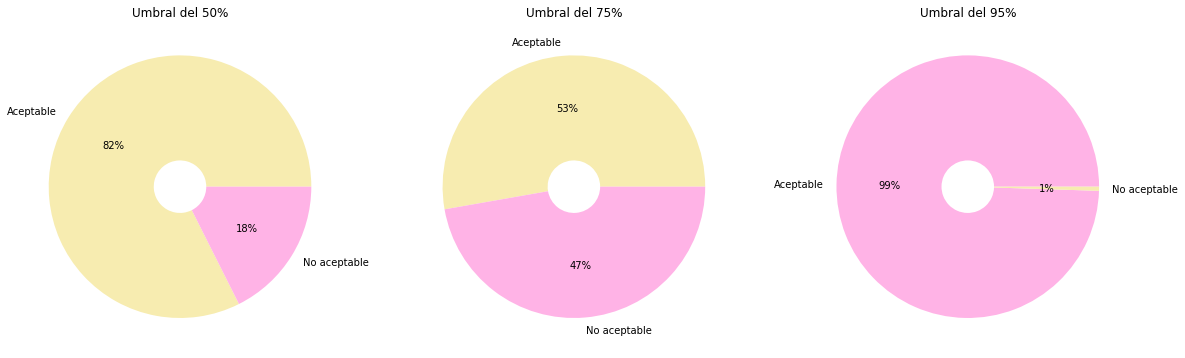

In [104]:
colors = ['#f7ecb0', '#ffb3e6']
labels = ['Aceptable', 'No aceptable']

fig, axes = plt.subplots(1, 3,
            figsize=(20,10))

axe0 = axes[0].pie(atributos_nuevo['TP_50'].value_counts(),
            autopct='%1.0f%%',
           colors= colors,
            labels= labels,        
           wedgeprops=dict(width=.8))
axe0 = axes[0].set_title('Umbral del 50%', fontsize = 12)
fig = axe0.get_figure()


axe1= axes[1].pie(atributos_nuevo['TP_75'].value_counts(),
            autopct='%1.0f%%',
           colors= colors,
            labels= labels,        
           wedgeprops=dict(width=.8))
axe1=axes[1].set_title('Umbral del 75%', fontsize = 12)
fig = axe1.get_figure()

axe2=axes[2].pie(atributos_nuevo['TP_95'].value_counts(),
           autopct='%1.0f%%',
           colors= ['#ffb3e6','#f7ecb0'],
            labels= labels,        
           wedgeprops=dict(width=.8))
axe2=axes[2].set_title('Umbral del 95%', fontsize = 12)
fig = axe2.get_figure()

plt.show()

# fig.savefig("Criterios_threshold_iou.png")

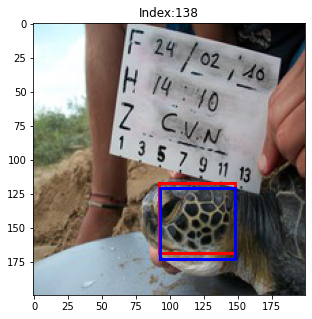

In [105]:
# Cambiar idx para ver diferentes imagenes
## LA PREGUNTA ES ¿TENDRÍA QUE RECORTARTLA DE NUEVO?
from matplotlib.pyplot import imshow
%matplotlib inline
fig, ax = plt.subplots(figsize=(5,5))
idx = 138
image = dataset_eval[idx]['image']
im = Image.fromarray(image.type(torch.uint8).numpy())
ax.imshow(im)
bb_label = dataset_eval[idx]['bbox']
add_bb_to_axes(ax, bb_label, color = 'red')
with torch.no_grad():
    data = image.permute([2,1,0]).unsqueeze(0)
    target = bb_label.unsqueeze(0)
    target = target.reshape([int(target.numel()/4),4]).type(torch.float)
    output = best_model(data)
    bb_inference = output.reshape([2,2])
    add_bb_to_axes(ax, bb_inference, color = 'blue')
    fig = ax.set_title(f"Index:{idx}", fontdict = {'fontsize':12})
    fig = fig.get_figure()    
#     fig.savefig("GT vs predicted_.png")

In [106]:
### Levantar el excel

In [107]:
archivo = 'C:/Users/Usuario/Documents/Tesis MEA/Subir a Drive/Adelantos/EvaluacionVisual.xlsx'
df = pd.read_excel(archivo)

In [108]:
# Armar esta lista con las decisiones que tomemos al mirar las fotos
atributos_nuevo['TP_visual'] = df['Visual']

In [109]:
atributos_nuevo.divergence.unique()

array([0.])

# Clasificación

In [110]:
atributos_nuevo= atributos_nuevo.set_index('index')


In [111]:
atributos_nuevo = atributos_nuevo.drop(columns =[ 'divergence', 'root_mean_squared_error'])

In [112]:
atributos_nuevo.columns

Index(['porcentaje_area', 'mean_squared_error', 'mean_absolute_error',
       'gausian', 'huber', 'smoth', 'iou', 'TP_50', 'TP_75', 'TP_95',
       'TP_visual'],
      dtype='object')

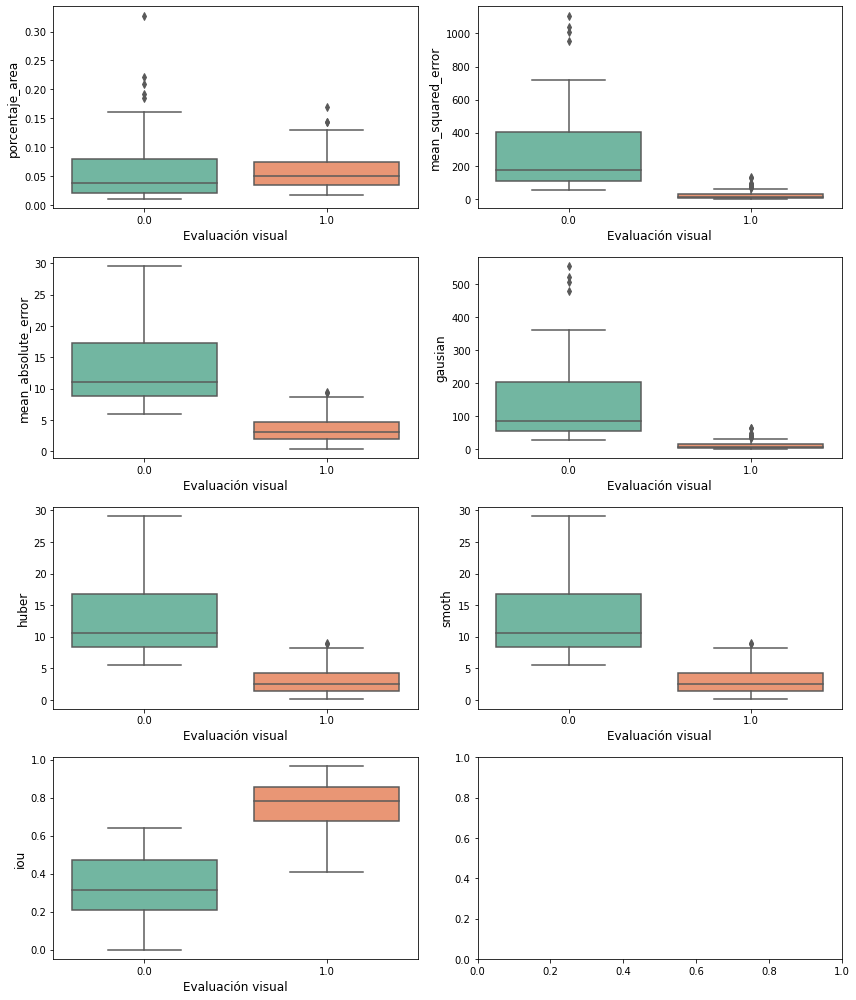

In [113]:
import seaborn as sns

lista = ['porcentaje_area', 'mean_squared_error', 'mean_absolute_error'
       , 'gausian', 'huber', 'smoth', 'iou']

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 14))
for idx, column in enumerate(lista):
    ax = axes[int(idx / 2), idx % 2]
    sns.boxplot(x='TP_visual', y=column, data=atributos_nuevo, ax=ax, palette = 'Set2')
    ax.set_xlabel('Evaluación visual',  fontsize=12)
    fig = ax.set_ylabel(column, fontsize=12)
    fig = fig.get_figure()    
#     fig.savefig("Variables_Criterio_visual.png")
fig.tight_layout();

In [114]:
# atributos_nuevo = data

atributos_nuevo.groupby('TP_visual').size()

TP_visual
0.0     40
1.0    159
dtype: int64

In [115]:
X = atributos_nuevo.drop(columns=['TP_visual', 'TP_50', 'TP_75', 'TP_95'])
y = atributos_nuevo['TP_visual']

In [116]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=1)

X_train, X_eval, y_train, y_eval= train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.1,
                                                    random_state=1)
print(X_train.shape)
print(X_test.shape)
print(X_eval.shape)

(143, 7)
(40, 7)
(16, 7)


En esta página dice que no afecta el resample 
https://medium.com/@160shelf/decision-tree-on-imbalanced-dataset-f1575414a6c2

No preprocessing and Oversampling showed almost the same performance (with only 0,01% difference) which tell us that imbalanced dataset does not affect Decision Tree’s performance. This proves the theory that Decision Tree works well with imbalanced data.

#tambien probamos con class_weight='balanced' y da peor la precisión

## Arbol de decisión --> ARBOL1 SIN OPTIMIZACIÓN

The prediction accuracy in train is:  98.6 %
The prediction accuracy in test is:  87.5 %


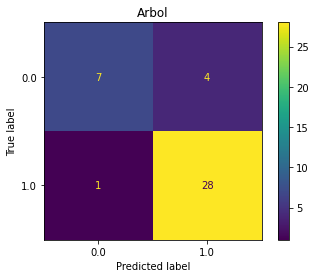

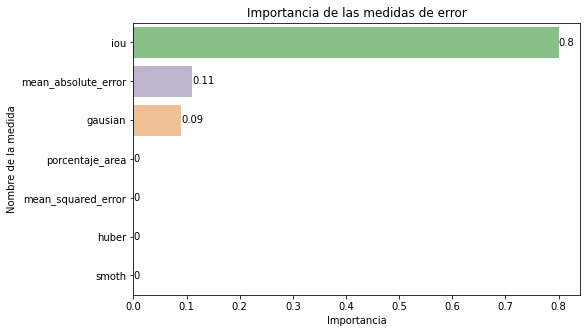

In [117]:
#armamos el árbol de decisión
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

arbol1 = tree.DecisionTreeClassifier(max_depth=3)
arbol1 = arbol1.fit(X_train, y_train)

print("The prediction accuracy in train is: ",round(arbol1.score(X_train,y_train)*100,2),"%")
print("The prediction accuracy in test is: ",round(arbol1.score(X_test,y_test)*100,2),"%")

plot_confusion_matrix(arbol1,X_test,y_test)
plt.title('Arbol')
plt.show()


feature_imp = pd.Series(arbol1.feature_importances_,
                        index=X.columns).sort_values(ascending=False)
feature_imp=pd.DataFrame(round(feature_imp,2), columns=['Importancia']).reset_index()
feature_imp = feature_imp.rename(columns={'index':'Medidas de error'})
feature_imp.columns

#Define size of bar plot
plt.figure(figsize=(8,5))
#Plot Searborn bar chart
paleta= sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
ax = sns.barplot(x=feature_imp['Importancia'], y=feature_imp['Medidas de error'], palette='Accent')

#Add chart labels
ax.bar_label(ax.containers[0])

plt.title('Importancia de las medidas de error')
plt.xlabel('Importancia')
plt.ylabel('Nombre de la medida')
fig = ax.get_figure()    
fig.savefig("imagenes_tesis/sin_opt_features.png")

In [134]:
from sklearn.metrics import classification_report

report=classification_report(y_test,
                             arbol1.predict(X_test),
                             target_names=['No aceptable', 'Aceptable'],
                             output_dict=True,
                             digits=2)

df_report = pd.DataFrame(report).transpose()
print(df_report)

# df_report.to_csv('sin_opt_report.csv', index= True)

df_report.to_latex('sin_opt_report.tex')

              precision    recall  f1-score  support
No aceptable      0.875  0.636364  0.736842   11.000
Aceptable         0.875  0.965517  0.918033   29.000
accuracy          0.875  0.875000  0.875000    0.875
macro avg         0.875  0.800940  0.827437   40.000
weighted avg      0.875  0.875000  0.868205   40.000


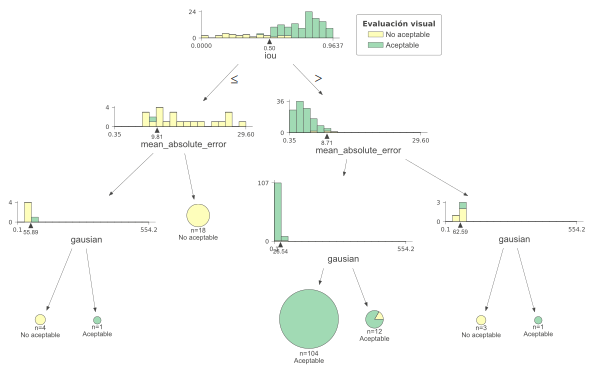

In [119]:
from dtreeviz.trees import dtreeviz # remember to load the package

viz = dtreeviz(arbol1, X_train, y_train,
                target_name="Evaluación visual",
                feature_names=X_train.columns,
                class_names=['No aceptable','Aceptable']
              )


viz.save("imagenes_tesis/sin_opt_arbol.svg") # suffix determines the generated image format
viz.view() 
viz

# Validación cruzada

In [120]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [121]:
param_grid = { 'criterion':['gini','entropy'],
              'splitter': ['best', 'random'],
                  'max_depth': [3],
              'min_samples_split': np.arange(0, 15),
              'min_samples_leaf' : [1,2,5],
                  'random_state' : np.arange(0, 15)
                 }
dtree_model=DecisionTreeClassifier()

dtree_gs = GridSearchCV(estimator=dtree_model,
                       param_grid=param_grid,
                       scoring='roc_auc',
                        cv=5)
dtree_gs.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [3],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'random_state': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'splitter': ['best', 'random']},
             scoring='roc_auc')

DecisionTreeClassifier(max_depth=3, min_samples_leaf=2, random_state=4,
                       splitter='random')
The prediction accuracy in train is:  94.40559 %
The prediction accuracy in test is:  95.0 %


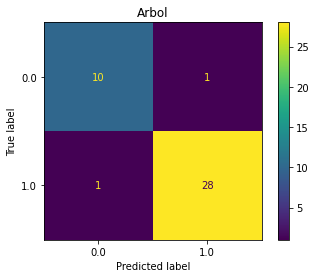

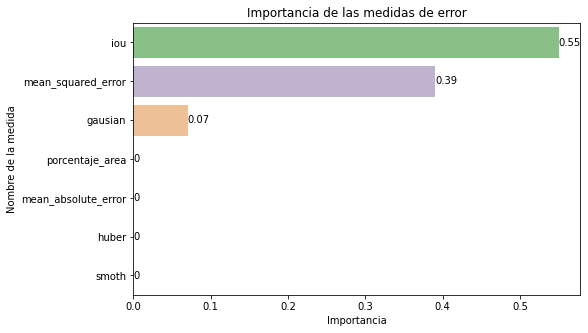

In [141]:
print(dtree_gs.best_estimator_)
arbol2_val =dtree_gs.best_estimator_.fit(X_train , y_train)

print("The prediction accuracy in train is: ",round(arbol2_val.score(X_train,y_train)*100,5),"%")
print("The prediction accuracy in test is: ",round(arbol2_val.score(X_test,y_test)*100,5),"%")

plot_confusion_matrix(arbol2_val,X_test,y_test)
plt.title('Arbol')
plt.show()


feature_imp = pd.Series(arbol2_val.feature_importances_,
                        index=X.columns).sort_values(ascending=False)
feature_imp=pd.DataFrame(round(feature_imp,2), columns=['Importancia']).reset_index()
feature_imp = feature_imp.rename(columns={'index':'Medidas de error'})
feature_imp.columns

#Define size of bar plot
plt.figure(figsize=(8,5))
#Plot Searborn bar chart
ax = sns.barplot(x=feature_imp['Importancia'], y=feature_imp['Medidas de error'], palette="Accent")
#Add chart labels
ax.bar_label(ax.containers[0])
plt.title('Importancia de las medidas de error')
plt.xlabel('Importancia')
plt.ylabel('Nombre de la medida')
fig = ax.get_figure()    
fig.savefig("imagenes_tesis/opt_features.png")

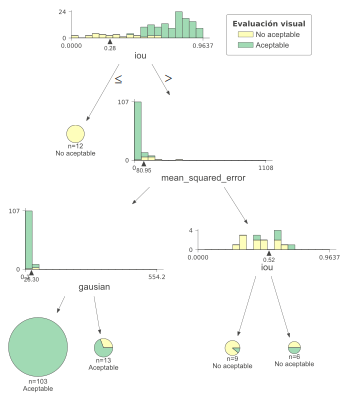

In [143]:
viz = dtreeviz(arbol2_val, X_train, y_train,
                target_name="Evaluación visual",
                feature_names=X_train.columns,
                class_names=['No aceptable','Aceptable']
              )
# viz.save("imagenes_tesis/opt_arbol.svg") # suffix determines the generated image format
viz.view() 
viz

In [136]:
from sklearn.metrics import classification_report

report=classification_report(y_test,
                             arbol2_val.predict(X_test),
                             target_names=['No aceptable', 'Aceptable'],
                             output_dict=True,
                             digits=2)

df_report = pd.DataFrame(report).transpose()
print(df_report)

# df_report.to_csv('opt_report.csv', index= True)
df_report.to_latex('opt_report.tex')

              precision    recall  f1-score  support
No aceptable   0.909091  0.909091  0.909091    11.00
Aceptable      0.965517  0.965517  0.965517    29.00
accuracy       0.950000  0.950000  0.950000     0.95
macro avg      0.937304  0.937304  0.937304    40.00
weighted avg   0.950000  0.950000  0.950000    40.00


In [125]:
## Arbol con max depth = 2

The prediction accuracy in train is:  94.40559 %
The prediction accuracy in test is:  95.0 %


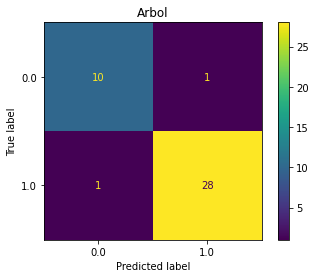

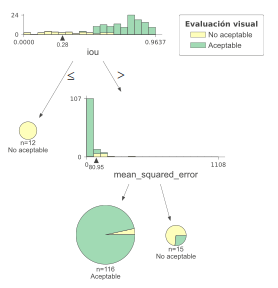

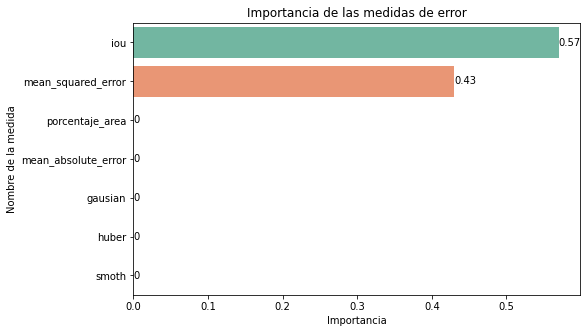

In [148]:
arbol_val_2_nodo = tree.DecisionTreeClassifier(max_depth=2,
                                     min_samples_leaf=2,
                                     random_state=4,
                                     splitter='random')
arbol_val_2_nodo = arbol_val_2_nodo.fit(X_train, y_train)

print("The prediction accuracy in train is: ",round(arbol_val_2_nodo.score(X_train,y_train)*100,5),"%")
print("The prediction accuracy in test is: ",round(arbol_val_2_nodo.score(X_test,y_test)*100,5),"%")

plot_confusion_matrix(arbol_val_2_nodo,X_test,y_test)
plt.title('Arbol')
plt.show()


feature_imp = pd.Series(arbol_val_2_nodo.feature_importances_,
                        index=X.columns).sort_values(ascending=False)
feature_imp=pd.DataFrame(round(feature_imp,2), columns=['Importancia']).reset_index()
feature_imp = feature_imp.rename(columns={'index':'Medidas de error'})
feature_imp.columns

#Define size of bar plot
plt.figure(figsize=(8,5))
#Plot Searborn bar chart
ax = sns.barplot(x=feature_imp['Importancia'], y=feature_imp['Medidas de error'], palette="Set2")
#Add chart labels
ax.bar_label(ax.containers[0])

plt.title('Importancia de las medidas de error')
plt.xlabel('Importancia')
plt.ylabel('Nombre de la medida')
fig = ax.get_figure()    
# fig.savefig("Feature_impt3.png")

viz = dtreeviz(arbol_val_2_nodo, X_train, y_train,
                target_name="Evaluación visual",
                feature_names=X_train.columns,
                class_names=['No aceptable','Aceptable']
              )
# viz.save("imagenes_tesis/opt_arbol_2_node.svg") # suffix determines the generated image format
viz.view() 
viz

In [127]:
## Arbol con max depth = 1

The prediction accuracy in train is:  89.51 %
The prediction accuracy in test is:  82.5 %


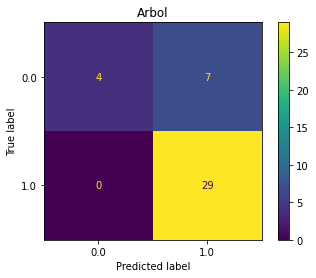

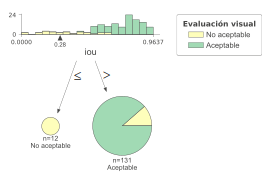

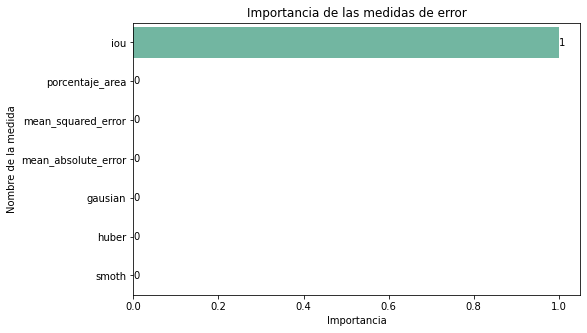

In [128]:
arbol_val_1_nodo = tree.DecisionTreeClassifier(max_depth=1,
                                     min_samples_leaf=2,
                                     random_state=4,
                                     splitter='random')
arbol_val_1_nodo = arbol_val_1_nodo.fit(X_train, y_train)

print("The prediction accuracy in train is: ",round(arbol_val_1_nodo.score(X_train,y_train)*100,2),"%")
print("The prediction accuracy in test is: ",round(arbol_val_1_nodo.score(X_test,y_test)*100,2),"%")

plot_confusion_matrix(arbol_val_1_nodo,X_test,y_test)
plt.title('Arbol')
plt.show()


feature_imp = pd.Series(arbol_val_1_nodo.feature_importances_,
                        index=X.columns).sort_values(ascending=False)
feature_imp=pd.DataFrame(round(feature_imp,2), columns=['Importancia']).reset_index()
feature_imp = feature_imp.rename(columns={'index':'Medidas de error'})
feature_imp.columns

#Define size of bar plot
plt.figure(figsize=(8,5))
#Plot Searborn bar chart
ax = sns.barplot(x=feature_imp['Importancia'], y=feature_imp['Medidas de error'], palette="Set2")
#Add chart labels
ax.bar_label(ax.containers[0])

plt.title('Importancia de las medidas de error')
plt.xlabel('Importancia')
plt.ylabel('Nombre de la medida')
fig = ax.get_figure()    
# fig.savefig("Feature_impt3.png")

viz = dtreeviz(arbol_val_1_nodo, X_train, y_train,
                target_name="Evaluación visual",
                feature_names=X_train.columns,
                class_names=['No aceptable','Aceptable']
              )
viz.save("imagenes_tesis/opt_arbol_1_node.svg") # suffix determines the generated image format
viz.view() 
viz

### Nuestra nueva regla, es un predict del arbol --> comparemos con el visual y con los criterios

In [129]:
atributos_nuevo.columns
X_eval

,porcentaje_area,mean_squared_error,mean_absolute_error,gausian,huber,smoth,iou
index,,,,,,,
18,0.057375,293.310699,16.953781,146.655350,16.453781,16.453781,0.276964
309,0.055125,3.956126,1.904287,1.978063,1.405018,1.405018,0.855557
304,0.032400,2.300243,1.192648,1.150121,0.816415,0.816415,0.879819
96,0.032375,5.587044,2.153088,2.793522,1.678883,1.678883,0.798049
191,0.029750,48.848869,6.068354,24.424435,5.568354,5.568354,0.544919
64,0.122400,43.665504,5.170601,21.832752,4.670601,4.670601,0.735948
252,0.033300,8.142964,2.411631,4.071482,1.927827,1.927827,0.780112
599,0.072800,8.673927,2.402798,4.336964,1.949406,1.949406,0.834160
207,0.027200,24.971739,4.971617,12.485869,4.471617,4.471617,0.590692


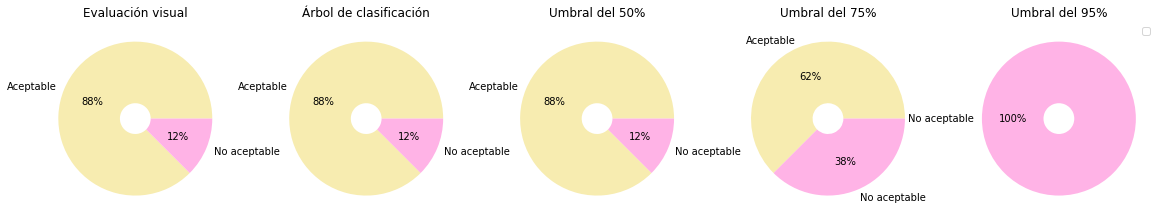

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=1)

X_train, X_eval, y_train, y_eval= train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.1,
                                                    random_state=1)

X_eval['pred_arbol'] =arbol_val_2_nodo.predict(X_eval)
X_eval_pred =X_eval.merge(atributos_nuevo.drop(columns=['porcentaje_area',
                                                        'mean_squared_error', 
                                                        'mean_absolute_error',
                                                        'gausian',
                                                        'huber',
                                                        'smoth',
                                                        'iou']),
                          on= 'index', how='left')


colors = ['#f7ecb0', '#ffb3e6']
labels = ['Aceptable', 'No aceptable']

fig, axes = plt.subplots(1, 5,
            figsize=(20,10))


axes[0].pie(X_eval_pred['TP_visual'].value_counts(),
            autopct='%1.0f%%',
           colors= colors,
            labels= labels,        
           wedgeprops=dict(width=.8))
axes[0].set_title('Evaluación visual', fontsize = 12)


axes[1].pie(X_eval_pred['pred_arbol'].value_counts(),
            autopct='%1.0f%%',
           colors= colors,
            labels= labels,        
           wedgeprops=dict(width=.8))
axes[1].set_title('Árbol de clasificación', fontsize = 12)


axes[2].pie(X_eval_pred['TP_50'].value_counts(),
           autopct='%1.0f%%',
           colors= colors,
            labels= labels,        
           wedgeprops=dict(width=.8))
axes[2].set_title('Umbral del 50%', fontsize = 12)


axes[3].pie(X_eval_pred['TP_75'].value_counts(),
            autopct='%1.0f%%',
           colors= colors,
            labels= labels,        
           wedgeprops=dict(width=.8))
axes[3].set_title('Umbral del 75%', fontsize = 12)


axes[4].pie(X_eval_pred['TP_95'].value_counts(),
            autopct='%1.0f%%',
           colors= ['#ffb3e6'],
            labels= ['No aceptable'],        
           wedgeprops=dict(width=.8))
axes[4].set_title('Umbral del 95%', fontsize = 12)

plt.legend(colors, labels)
plt.show()

# fig.savefig("imagenes_tesis/opt_threshold.png")

In [131]:
# With Learnable Parameters
m = nn.BatchNorm2d(100)
# Without Learnable Parameters
# m = nn.BatchNorm2d(100, affine=False)
input = torch.randn(20, 100, 35, 45)
output = m(input)
output.mean()

tensor(3.8752e-11, grad_fn=<MeanBackward0>)